In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
from PIL import Image

# Ouvrir les deux images
image1 = Image.open('../data/images/background1.png')
image2 = Image.open('../data/images/picasso.jpg')

# Récupérer les dimensions de la première image
width1, height1 = image1.size

# Redimensionner la deuxième image aux dimensions de la première
image2 = image2.resize((width1, height1))

# Enregistrer la deuxième image redimensionnée
image2.save('../data/images/picasso_aaa.jpg')

In [4]:
from PIL import Image

def convert_jpg_to_png(jpg_path, png_path):
    img = Image.open(jpg_path)
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    else:
        # If the image already has an alpha channel, ensure it's fully opaque
        pixels = img.load()
        for py in range(img.size[1]):
            for px in range(img.size[0]):
                r, g, b, a = pixels[px, py]
                if a < 255:
                    pixels[px, py] = (r, g, b, 255)
    img.save(png_path, 'PNG')


In [34]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Set the device to use for the model and data
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU


# Define a function to load and preprocess an image
def image_loader(image_name, convert_to_rgb=False):
    image = Image.open(image_name)
    if convert_to_rgb:
        image = image.convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = transforms.ToTensor()(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load the content and style images
painting_name = "../data/images/picasso"
asset_name = "../data/images/house1"
style_img = image_loader(painting_name+'.jpg')
content_img = image_loader(asset_name+'.png', convert_to_rgb=True)
layer = image_loader(asset_name+'.png')

# Get the sizes of both style and content images
style_img_size = style_img.size()
content_img_size = content_img.size()

desired_aspect_ratio = (content_img_size[3] / content_img_size[2])  # Height / Width of the content image

# Calculate the new width based on the desired aspect ratio
new_width = int(style_img_size[3] * desired_aspect_ratio)
new_height = int(style_img_size[2] / desired_aspect_ratio)

style_img_resized = transforms.Resize((content_img_size[2], content_img_size[3]))(style_img)



# Print the sizes of the style and content image tensors
print(str(style_img_resized.size()) + '     ' + str(content_img.size())+ str(layer.size()))

torch.Size([1, 3, 488, 511])     torch.Size([1, 3, 488, 511])torch.Size([1, 4, 488, 511])


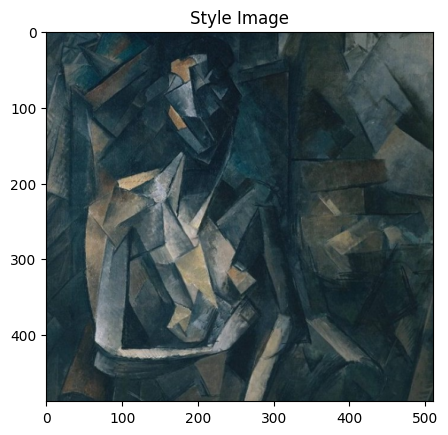

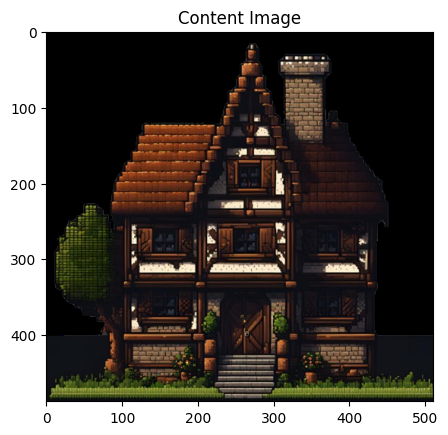

In [22]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(image, title=None):
    if isinstance(image, torch.Tensor):
        image = image.cpu().clone()  # we clone the tensor to not do changes on it
        image = image.squeeze(0)      # remove the fake batch dimension
        image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure()
imshow(style_img_resized, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [23]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [24]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [25]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [26]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [27]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [28]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

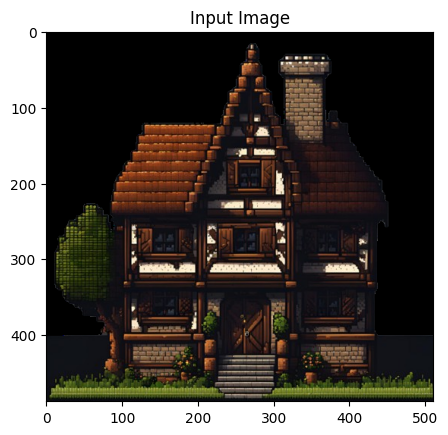

torch.Size([1, 3, 488, 511])


In [29]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# .. code-block:: python
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
print(input_img.size())

In [30]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [31]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 31.400064 Content Loss: 21.363131

run [100]:
Style Loss : 8.526391 Content Loss: 15.754394

run [150]:
Style Loss : 5.540299 Content Loss: 12.847712

run [200]:
Style Loss : 3.417784 Content Loss: 11.206973

run [250]:
Style Loss : 1.774682 Content Loss: 10.192534

run [300]:
Style Loss : 0.931894 Content Loss: 9.402742



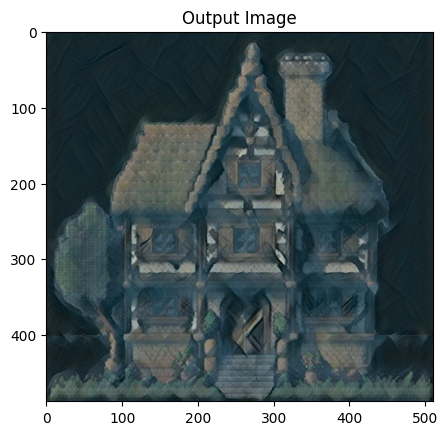

In [32]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_resized, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
output_img = transforms.ToPILImage()(output.cpu().squeeze(0))
output_img.save(asset_name+"_modified.jpg")

In [42]:
from PIL import Image, ImageOps

# Ouvrir les images
img_jpg = Image.open(asset_name+'_modified.jpg')
img_png = Image.open(asset_name+'.png')

# Convertir les images en mode RGBA
img_jpg = img_jpg.convert("RGBA")
img_png = img_png.convert("RGBA")

# Créer un masque à partir de l'image PNG
mask = img_png.split()[-1]  # Récupérer le canal alpha
mask = mask.point(lambda i: i > 0 and 255)  # Binariser le masque
mask = ImageOps.invert(mask)  # Inverser le masque

# Appliquer le masque sur l'image JPG
img_jpg.paste((0, 0, 0, 255), mask=mask)  # Remplacer les pixels en dehors du masque par de la transparence

# Rogner l'image en fonction du masque
bbox = mask.getbbox()  # Récupérer les coordonnées du rectangle englobant
img_jpg = img_jpg.crop(bbox)

# Enregistrer le résultat
img_jpg.save(asset_name+"_result.png")

In [44]:
from PIL import Image, ImageOps

img_jpg = Image.open(asset_name+'_modified.jpg')
img_png = Image.open(asset_name+'.png')

# Convertir les images en mode RGBA
img_jpg = img_jpg.convert("RGBA")
img_png = img_png.convert("RGBA")

# Créer un masque à partir de l'image PNG
mask = img_png.split()[3]  # Récupérer le canal alpha
mask = ImageOps.invert(mask)  # Inverser le masque

# Appliquer le masque sur l'image JPG
img_jpg.paste((255, 255, 255, 0), mask=mask)  # Remplacer les pixels en dehors du masque par de la transparence

# Trouver les coordonnées de rognage
bbox = mask.getbbox()

# Rogner l'image en fonction du masque
img_jpg = img_jpg.crop(bbox)

# Enregistrer le résultat
img_jpg.save(asset_name+"_result.png")